In [4]:
import os
import glob
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ── 1. デバイス設定 ──
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── 2. MNIST テストデータローダー ──
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4)

# ── 3. モデルクラス定義のプレースホルダ ──
#     training 時に使ったモデル定義をコピペしてください
# ── 3. モデルクラス定義 ──
import torch.nn as nn

class YourModelClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), 
            nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128), 
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

# ── 4. モデルファイルのパス取得 ──
model_dir = "../../experiments/exp8_cl32_train_1000(10x)/MNIST_cl32_attclimit7_datasize1000_distg[0, 1, 2, 3, 4, 5, 6, 7]_groups[0, 8, 16, 24]_ep400_alpha0.5_20250703_145456/models"
# special characters をエスケープ
escaped_dir = glob.escape(model_dir)

# .pth を取得
model_paths = sorted(glob.glob(os.path.join(escaped_dir, "*.pth")))
print(f"Found {len(model_paths)} models.")

# ── 5. 各モデルで MNIST テストを一度だけ回し、ロジットと予測ラベルを保存 ──
outputs = []
for mp in model_paths:
    model = YourModelClass().to(device)
    state = torch.load(mp, map_location=device)
    # もし state_dict だけが保存されている場合:
    if isinstance(state, dict) and "state_dict" in state:
        model.load_state_dict(state["state_dict"])
    else:
        model.load_state_dict(state)
    model.eval()

    all_logits = []
    all_preds  = []
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            logits = model(x)                      # shape: [B,10]
            preds  = logits.argmax(dim=1)          # shape: [B]
            all_logits.append(logits.cpu().numpy())
            all_preds .append(preds.cpu().numpy())

    logits_np = np.concatenate(all_logits, axis=0)  # shape: [N,10]
    preds_np  = np.concatenate(all_preds,  axis=0)  # shape: [N]
    outputs.append({"logits": logits_np, "preds": preds_np})

# ── 6. 任意の2モデルペアごとに、サンプルごとの類似度を計算 ──
argmax_sims = []
cos_sims    = []

for out_a, out_b in combinations(outputs, 2):
    # ① Argmax の一致 (0 or 1)
    same = (out_a["preds"] == out_b["preds"]).astype(int)
    argmax_sims.extend(same.tolist())

    # ② ロジットのコサイン類似度 (サンプルごとに)
    #    ※たとえば sklearn の cosine_similarity を利用
    sim_batch = cosine_similarity(out_a["logits"], out_b["logits"])
    # 対角要素だけ取り出す
    diag_sim  = np.diag(sim_batch)
    cos_sims.extend(diag_sim.tolist())

# ── 7. ヒストグラムでプロット ──
plt.figure(figsize=(6,4))
plt.hist(argmax_sims, bins=[-0.5,0.5,1.5], density=True, rwidth=0.6)
plt.xticks([0,1])
plt.xlabel("Argmax match (1) / mismatch (0)")
plt.ylabel("Proportion")
plt.title("Distribution of Argmax Similarity")
plt.grid(True)

plt.figure(figsize=(6,4))
plt.hist(cos_sims, bins=50, density=False)
plt.xlabel("Cosine similarity of logits")
plt.ylabel("Count")
plt.title("Distribution of Logit Cosine Similarity")
plt.grid(True)

plt.tight_layout()
plt.show()


Found 8 models.


RuntimeError: Error(s) in loading state_dict for YourModelClass:
	Missing key(s) in state_dict: "model.0.weight", "model.0.bias", "model.2.weight", "model.2.bias", "model.7.weight", "model.7.bias", "model.10.weight", "model.10.bias". 
	Unexpected key(s) in state_dict: "0.weight", "0.bias", "2.weight", "2.bias", "7.weight", "7.bias", "10.weight", "10.bias". 

Found 8 models.


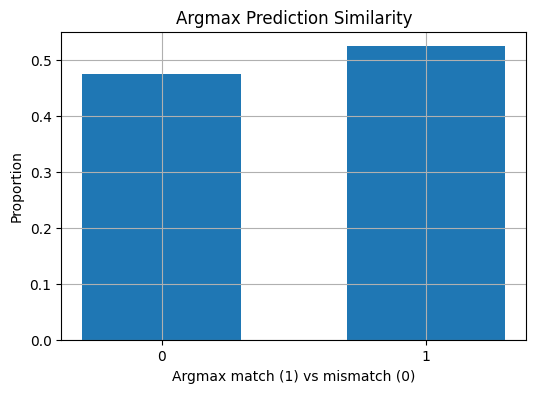

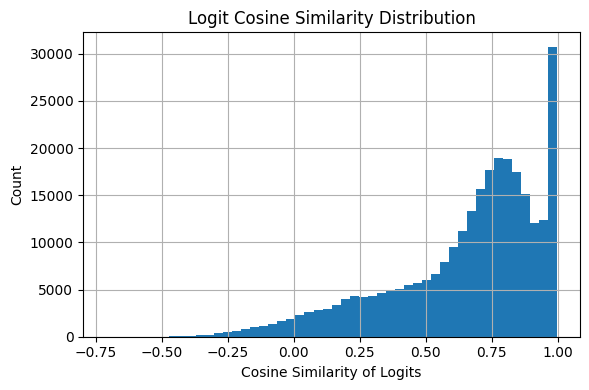

In [8]:
import os
import torch
import numpy as np
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

# ── 1. デバイス設定 ──
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── 2. MNIST テストデータローダー ──
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4)

# ── 3. モデル定義 ──
class YourModelClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

# ── 4. モデルファイル一覧取得 ──
model_dir = (
    "../../experiments/exp8_cl32_train_1000(10x)/"
    "MNIST_cl32_attclimit7_datasize1000_distg[0, 1, 2, 3, 4, 5, 6, 7]_"
    "groups[0, 1, 2, 3]_ep400_alpha0.5_20250703_141729/models"
)
model_paths = [
    os.path.join(model_dir, fn)
    for fn in os.listdir(model_dir)
    if fn.endswith(".pth")
]
model_paths.sort()
print(f"Found {len(model_paths)} models.")

# ── 5. 各モデルで一度だけ推論してロジット・予測を保存 ──
outputs = []
for path in model_paths:
    model = YourModelClass().to(device)
    # checkpoint をロード
    ckpt = torch.load(path, map_location=device)
    state_dict = ckpt.get("state_dict", ckpt)

    # キーが数字プレフィックスなら model.model にロード
    if all(k.split('.')[0].isdigit() for k in state_dict.keys()):
        model.model.load_state_dict(state_dict)
    else:
        model.load_state_dict(state_dict)

    model.eval()
    all_logits = []
    all_preds = []
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            logits = model(x)                  # [B, 10]
            preds = logits.argmax(dim=1)       # [B]
            all_logits.append(logits.cpu().numpy())
            all_preds .append(preds.cpu().numpy())

    outputs.append({
        "logits": np.concatenate(all_logits, axis=0),
        "preds":  np.concatenate(all_preds,  axis=0)
    })

# ── 6. モデルペアごとに類似度算出 ──
argmax_sims = []
cos_sims    = []

for out_a, out_b in combinations(outputs, 2):
    # (1) Argmax match → 0 or 1
    argmax_sims.extend((out_a["preds"] == out_b["preds"]).astype(int).tolist())
    # (2) ロジットのコサイン類似度（対角成分のみ）
    C = cosine_similarity(out_a["logits"], out_b["logits"])
    cos_sims.extend(np.diag(C).tolist())

# ── 7. ヒストグラムで可視化 ──
plt.figure(figsize=(6,4))
plt.hist(argmax_sims, bins=[-0.5, 0.5, 1.5], density=True, rwidth=0.6)
plt.xticks([0, 1])
plt.xlabel("Argmax match (1) vs mismatch (0)")
plt.ylabel("Proportion")
plt.title("Argmax Prediction Similarity")
plt.grid(True)

plt.figure(figsize=(6,4))
plt.hist(cos_sims, bins=50)
plt.xlabel("Cosine Similarity of Logits")
plt.ylabel("Count")
plt.title("Logit Cosine Similarity Distribution")
plt.grid(True)

plt.tight_layout()
plt.show()


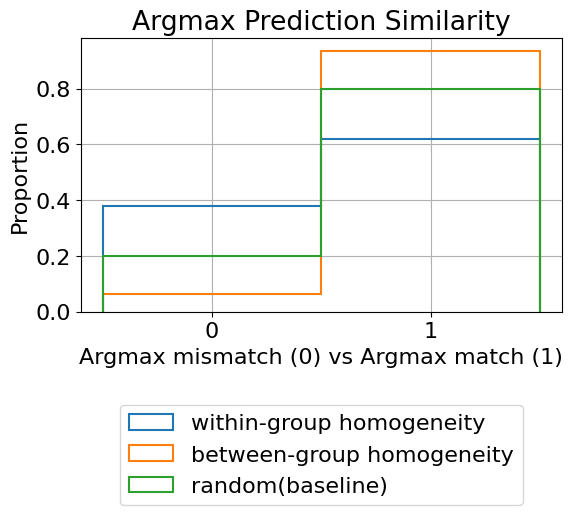

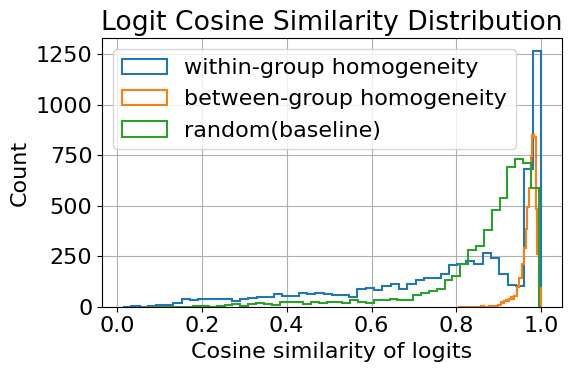

In [17]:
plt.rcParams.update({'font.size': 16})

import os
import torch
import numpy as np
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import random

# ── 設定 ──
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(0)
subset_size = 2000   # テストサンプル数を絞る
max_models = 3       # モデル数を絞る
n_pairs = 5          # モデルペア数を絞る

# ── MNIST テストデータローダー（サブセット） ──
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
full_test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
indices = list(range(len(full_test_ds)))
random.shuffle(indices)
subset_indices = indices[:subset_size]
test_ds = Subset(full_test_ds, subset_indices)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4)

# ── モデル定義 ──
class YourModelClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

# ── モデルディレクトリとラベル ──
model_dirs = [
    "../../experiments/exp8_cl32_train_1000(10x)/MNIST_cl32_attclimit7_datasize1000_distg[0, 1, 2, 3, 4, 5, 6, 7]_groups[0, 1, 2, 3]_ep400_alpha0.5_20250703_141729/models",
    "../../experiments/exp8_cl32_train_1000(10x)/MNIST_cl32_attclimit7_datasize1000_distg[0, 1, 2, 3, 4, 5, 6, 7]_groups[0, 8, 16, 24]_ep400_alpha0.5_20250703_145456/models",
    "../../experiments/exp8_cl32_train_1000(10x)/MNIST_cl32_attclimit7_datasize1000_distg[0, 1, 2, 3, 4, 5, 6, 7]_groups[1, 16, 21, 26]_ep400_alpha0.5_20250703_130232/models",
]
labels = ["within-group homogeneity", "between-group homogeneity", "random(baseline)"]

results = {}

# ── 各ディレクトリで類似度計算 ──
for model_dir, label in zip(model_dirs, labels):
    paths = sorted(
        os.path.join(model_dir, fn)
        for fn in os.listdir(model_dir)
        if fn.endswith(".pth")
    )[:max_models]

    outputs = []
    for p in paths:
        model = YourModelClass().to(device)
        ckpt = torch.load(p, map_location=device)
        sd = ckpt.get("state_dict", ckpt)
        if all(k.split('.')[0].isdigit() for k in sd.keys()):
            model.model.load_state_dict(sd)
        else:
            model.load_state_dict(sd)
        model.eval()

        logits_list, preds_list = [], []
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                logits = model(x).cpu().numpy()
                preds = logits.argmax(axis=1)
                logits_list.append(logits)
                preds_list.append(preds)
        outputs.append({
            "logits": np.concatenate(logits_list, axis=0),
            "preds":  np.concatenate(preds_list, axis=0)
        })

    pairs = list(combinations(range(len(outputs)), 2))
    sampled = random.sample(pairs, min(len(pairs), n_pairs))

    argmax_sims, cos_sims = [], []
    for i, j in sampled:
        a, b = outputs[i], outputs[j]
        argmax_sims.extend((a["preds"] == b["preds"]).astype(int))
        C = cosine_similarity(a["logits"], b["logits"])
        cos_sims.extend(np.diag(C))

    results[label] = {"argmax": argmax_sims, "cos": cos_sims}

# ── Argmax 一致度の重ね描き ──
plt.figure(figsize=(6,6))
for label, data in results.items():
    plt.hist(data["argmax"],
             bins=[-0.5, 0.5, 1.5],
             density=True,
             histtype="step",
             linewidth=1.5,
             label=label)
plt.xticks([0, 1])
plt.xlabel("Argmax mismatch (0) vs Argmax match (1)")
plt.ylabel("Proportion")
plt.title("Argmax Prediction Similarity")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()

# ── ロジットのコサイン類似度の重ね描き ──
plt.figure(figsize=(6,4))
for label, data in results.items():
    plt.hist(data["cos"],
             bins=50,
             histtype="step",
             linewidth=1.5,
             label=label)
plt.xlabel("Cosine similarity of logits")
plt.ylabel("Count")
plt.title("Logit Cosine Similarity Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


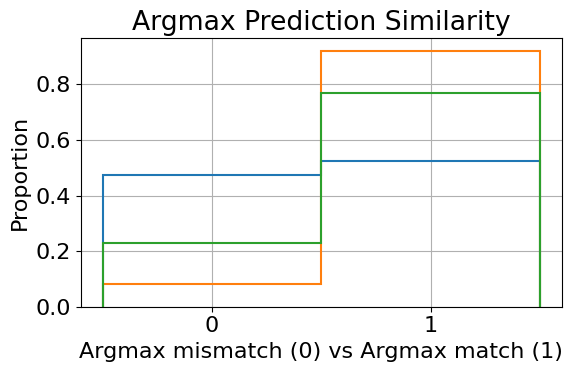

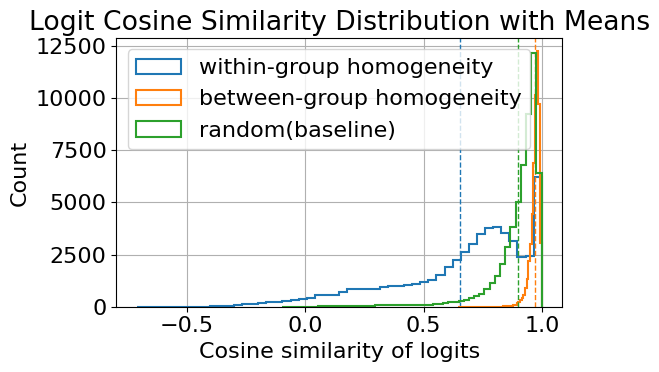

In [21]:
import os
import torch
import numpy as np
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import random

# ── 設定 ──
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(0)
subset_size = 2000    # テストサンプル数を絞る

# ── MNIST テストデータローダー（サブセット） ──
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
full_test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
indices = list(range(len(full_test_ds)))
random.shuffle(indices)
test_indices = indices[:subset_size]
test_ds = Subset(full_test_ds, test_indices)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4)

# ── モデル定義 ──
class YourModelClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

# ── モデルディレクトリとラベル ──
model_dirs = [
    "../../experiments/exp8_cl32_train_1000(10x)/"
    "MNIST_cl32_attclimit7_datasize1000_distg[0, 1, 2, 3, 4, 5, 6, 7]_"
    "groups[0, 1, 2, 3]_ep400_alpha0.5_20250703_141729/models",
    "../../experiments/exp8_cl32_train_1000(10x)/"
    "MNIST_cl32_attclimit7_datasize1000_distg[0, 1, 2, 3, 4, 5, 6, 7]_"
    "groups[0, 8, 16, 24]_ep400_alpha0.5_20250703_145456/models",
    "../../experiments/exp8_cl32_train_1000(10x)/"
    "MNIST_cl32_attclimit7_datasize1000_distg[0, 1, 2, 3, 4, 5, 6, 7]_"
    "groups[1, 16, 21, 26]_ep400_alpha0.5_20250703_130232/models",
]
labels = ["within-group homogeneity", "between-group homogeneity", "random(baseline)"]

results = {}

# ── 各ディレクトリでロジットと予測を収集 ──
for model_dir, label in zip(model_dirs, labels):
    logits_list = []
    preds_list = []
    for fn in sorted(os.listdir(model_dir)):
        if not fn.endswith(".pth"):
            continue
        path = os.path.join(model_dir, fn)
        model = YourModelClass().to(device)
        ckpt = torch.load(path, map_location=device)
        sd = ckpt.get("state_dict", ckpt)
        if all(k.split('.')[0].isdigit() for k in sd.keys()):
            model.model.load_state_dict(sd)
        else:
            model.load_state_dict(sd)
        model.eval()

        with torch.no_grad():
            batch_logits = []
            batch_preds = []
            for x, _ in test_loader:
                x = x.to(device)
                logits = model(x).cpu().numpy()
                batch_logits.append(logits)
                batch_preds.append(logits.argmax(axis=1))
            logits_list.append(np.vstack(batch_logits))
            preds_list.append(np.concatenate(batch_preds))

    # ── 全モデルペアで類似度計算（バッチ処理） ──
    num_samples = logits_list[0].shape[0]
    argmax_sims = []
    cos_sims = []
    for i, j in combinations(range(len(logits_list)), 2):
        pi = preds_list[i]
        pj = preds_list[j]
        argmax_sims.extend((pi == pj).astype(int))
        for start in range(0, num_samples, 256):
            end = min(start + 256, num_samples)
            bi = logits_list[i][start:end]
            bj = logits_list[j][start:end]
            C = cosine_similarity(bi, bj)
            cos_sims.extend(np.diag(C))

    results[label] = {"argmax": argmax_sims, "cos": cos_sims}

# ── Argmax 一致度のプロット ──
plt.figure(figsize=(6,4))
for label, data in results.items():
    plt.hist(
        data["argmax"],
        bins=[-0.5, 0.5, 1.5],
        density=True,
        histtype="step",
        linewidth=1.5,
        label=label
    )
plt.xticks([0, 1])
plt.xlabel("Argmax mismatch (0) vs Argmax match (1)")
plt.ylabel("Proportion")
plt.title("Argmax Prediction Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()

# ── ロジットのコサイン類似度の重ね描き（平均線付き、単一凡例） ──
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(6,4))
for idx, (label, data) in enumerate(results.items()):
    color = colors[idx % len(colors)]
    plt.hist(
        data["cos"],
        bins=50,
        histtype="step",
        linewidth=1.5,
        label=label,
        color=color
    )
    mean_val = np.mean(data["cos"])
    plt.axvline(mean_val, linestyle="--", linewidth=1.0, color=color)
plt.xlabel("Cosine similarity of logits")
plt.ylabel("Count")
plt.title("Logit Cosine Similarity Distribution with Means")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


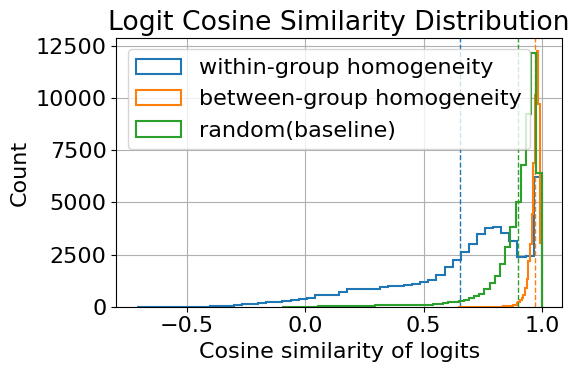

In [31]:
# ── ロジットのコサイン類似度の重ね描き（平均線付き、単一凡例） ──
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(6,4))
for idx, (label, data) in enumerate(results.items()):
    color = colors[idx % len(colors)]
    plt.hist(
        data["cos"],
        bins=50,
        histtype="step",
        linewidth=1.5,
        label=label,
        color=color
    )
    mean_val = np.mean(data["cos"])
    plt.axvline(mean_val, linestyle="--", linewidth=1.0, color=color)
plt.xlabel("Cosine similarity of logits")
plt.ylabel("Count")
plt.title("Logit Cosine Similarity Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


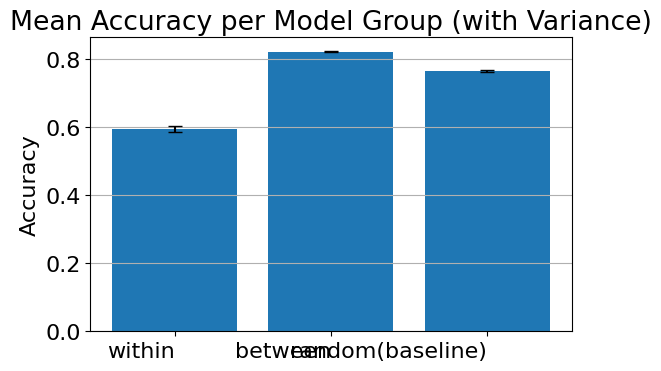

In [ ]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn

# ── 1. 設定 ──
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(0)
subset_size = 2000    # テストサンプル数を絞る

# ── 2. MNIST テストデータローダー（サブセット） ──
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
full_test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
indices = list(range(len(full_test_ds)))
random.shuffle(indices)
test_indices = indices[:subset_size]
test_ds = Subset(full_test_ds, test_indices)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4)

# ── 3. モデル定義 ──
class YourModelClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

# ── 4. モデルディレクトリとラベル ──
model_dirs = [
    "../../experiments/exp8_cl32_train_1000(10x)/"
    "MNIST_cl32_attclimit7_datasize1000_distg[0, 1, 2, 3, 4, 5, 6, 7]_"
    "groups[0, 1, 2, 3]_ep400_alpha0.5_20250703_141729/models",
    "../../experiments/exp8_cl32_train_1000(10x)/"
    "MNIST_cl32_attclimit7_datasize1000_distg[0, 1, 2, 3, 4, 5, 6, 7]_"
    "groups[0, 8, 16, 24]_ep400_alpha0.5_20250703_145456/models",
    "../../experiments/exp8_cl32_train_1000(10x)/"
    "MNIST_cl32_attclimit7_datasize1000_distg[0, 1, 2, 3, 4, 5, 6, 7]_"
    "groups[1, 16, 21, 26]_ep400_alpha0.5_20250703_130232/models",
]
labels = ["within", "between", "random\n(baseline)"]

# ── 5. 各モデルのテスト精度を計算 ──
means = []
vars_ = []

for model_dir in model_dirs:
    accs = []
    for fn in sorted(os.listdir(model_dir)):
        if not fn.endswith(".pth"):
            continue
        path = os.path.join(model_dir, fn)
        model = YourModelClass().to(device)

        # モデルロード
        ckpt = torch.load(path, map_location=device)
        sd = ckpt.get("state_dict", ckpt)
        if all(k.split('.')[0].isdigit() for k in sd.keys()):
            model.model.load_state_dict(sd)
        else:
            model.load_state_dict(sd)
        model.eval()

        # 推論で精度計算
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x).argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        accs.append(correct / total)

    means.append(np.mean(accs))
    vars_.append(np.var(accs))



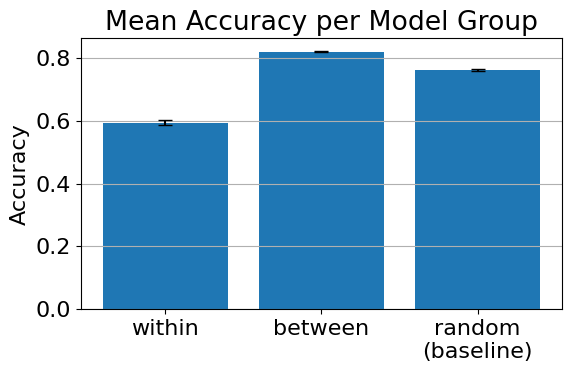

In [30]:
labels = ["within", "between", "random\n(baseline)"]
# ── 6. 平均精度と分散のバーグラフ ──
x = np.arange(len(labels))
plt.figure(figsize=(6,4))
plt.bar(
    x,
    means,
    yerr=vars_,
    capsize=5
)
plt.xticks(x, labels)
plt.ylabel("Accuracy")
plt.title("Mean Accuracy per Model Group")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
